# Perfect Information Case Analysis for the Sugarcane Mill Model

This notebook reads in historical price data for analysis of the perfect information case of the sugarcane mill model. The sensitivty of the frequency of scenarios in each operating mode to bio-jet fuel premium prices is also considered.

In [1]:
#stochastic_model_v2.py contains a function that builds the pyomo model of the sugarcane mill
from stochastic_model_v2 import *
import matplotlib.pyplot as plt
import pandas as pd

from perfect_information_analysis import *
from technology_sensitivity import *
from pathlib import Path  
import os

### Read in Historical Price Data

In [2]:
#Load historical price data
df_hp = pd.read_excel('Mutran_jet_datav2.xlsx', sheet_name= 'Inflation')

#Convert data frame to indexed dictionary and add the premium to SAF
jet_price = df_hp['p_je']
eth_price = df_hp['p_et']
sugar_price = df_hp['p_su']


jet_price = jet_price.to_dict()
eth_price = eth_price.to_dict()
sugar_price = sugar_price.to_dict()

market_prices = {}
market_prices['s'] = sugar_price
market_prices['e'] = eth_price
market_prices['a'] = jet_price

#Collect all scenarios in an array
scenarios = list(sugar_price.keys())

### Analyze the Nominal Case

In [3]:
#Nominal Case Data considering the conventional ATJ technology
conv = 0.409 #m3 jet/m3 eth
cost = 637 #$R/m3 jet
premium = 2585 #$R/m3 jet

#Run perfect information analysis function
data = perfect_information_data_gen(conv,cost,premium,market_prices,scenarios)

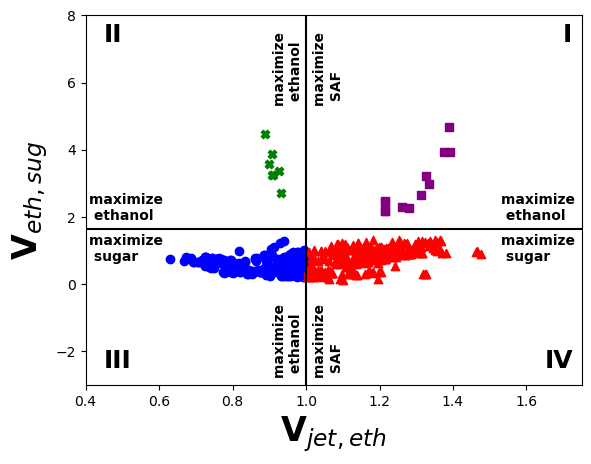

In [4]:
#Plot Quadrant Chart
#Rename data from results of the perfect information analysis function
df_region1half = data[0]
df_region2half = data[1]
df_region3half = data[2]
df_region4half = data[3]

#Plot the ratio data of each region
plt.scatter(df_region1half['ratio1'],df_region1half['ratio2'], color='blue', label='max sugar, max ethanol to market (\u03B8 = 1,\u03B3 = 0.6)',marker='o')
plt.scatter(df_region2half['ratio1'],df_region2half['ratio2'], color='red',label='max sugar, max SAF (\u03B8 = 1,\u03B3 = 0.2)',marker='^')
plt.scatter(df_region3half['ratio1'],df_region3half['ratio2'], color='green',label='max ethanol to market (\u03B8 = 0.4,\u03B3 = 0.6 )',marker='X')
plt.scatter(df_region4half['ratio1'],df_region4half['ratio2'], color='purple',label='max SAF (\u03B8 = 0.4,\u03B3 = 0.2 )',marker='s')
plt.xlabel('V$_{jet,eth}$', fontsize = 24,fontweight='bold')
plt.ylabel('V$_{eth,sug}$', fontsize=24, fontweight='bold')
plt.text(0.41,1.9,'maximize \n ethanol', fontweight='bold')
plt.text(0.41,0.7,'maximize \n sugar',fontweight='bold')
plt.text(1.53,1.9,'maximize \n ethanol', fontweight='bold')
plt.text(1.53,0.7,'maximize \n sugar',fontweight='bold')
plt.text(0.45,7.2,'II', fontweight='bold',fontsize=18)
plt.text(0.45,-2.5,'III', fontweight='bold',fontsize=18)
plt.text(1.7,7.2,'I', fontweight='bold',fontsize=18)
plt.text(1.65,-2.5,'IV', fontweight='bold',fontsize=18)
plt.text(0.91,5.4,'maximize \n ethanol', fontweight='bold',rotation=90)
plt.text(1.02,5.4,'maximize \n SAF', fontweight='bold',rotation=90)
plt.text(0.91,-2.7,'maximize \n ethanol', fontweight='bold',rotation=90)
plt.text(1.02,-2.7,'maximize \n SAF', fontweight='bold',rotation=90)
plt.axvline(1, color = 'black')
plt.axhline(1.64, color = 'black')
plt.ylim(top=8, bottom = -3)
plt.xlim(left=0.4, right = 1.75)
# plt.legend(bbox_to_anchor=(1.05, 1))
plt.savefig('Ratioshalf_v2.png',bbox_inches='tight', dpi=300)
plt.show()

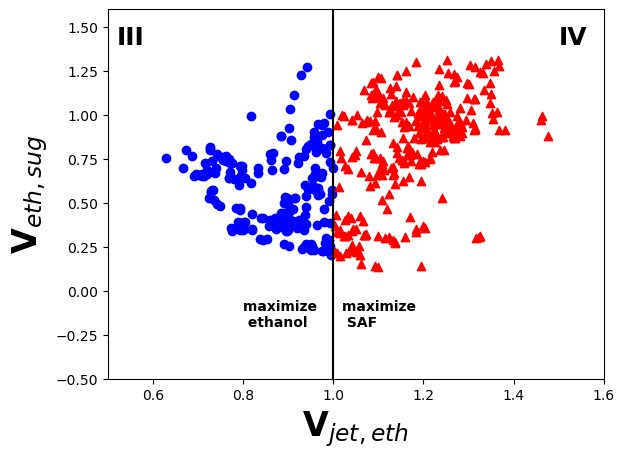

In [5]:
#Zoom in on Quadrants III and IV

plt.scatter(df_region1half['ratio1'],df_region1half['ratio2'], color='blue', label='max sugar, max ethanol to market (\u03B8 = 1,\u03B3 = 0.6)',marker='o')
plt.scatter(df_region2half['ratio1'],df_region2half['ratio2'], color='red',label='max sugar, max SAF (\u03B8 = 1,\u03B3 = 0.2)',marker='^')
plt.scatter(df_region3half['ratio1'],df_region3half['ratio2'], color='green',label='max ethanol to market (\u03B8 = 0.4,\u03B3 = 0.6 )',marker='X')
plt.scatter(df_region4half['ratio1'],df_region4half['ratio2'], color='purple',label='max SAF (\u03B8 = 0.4,\u03B3 = 0.2 )',marker='s')
plt.xlabel('V$_{jet,eth}$', fontsize = 24,fontweight='bold')
plt.ylabel('V$_{eth,sug}$', fontsize=24, fontweight='bold')
plt.text(0.52,1.4,'III', fontweight='bold',fontsize=18)
plt.text(1.5,1.4,'IV', fontweight='bold',fontsize=18)
plt.text(0.8,-0.2,'maximize \n ethanol', fontweight='bold')
plt.text(1.02,-0.2,'maximize \n SAF', fontweight='bold')
plt.axvline(1, color = 'black')
plt.axhline(1.64, color = 'black')
plt.ylim(top=1.6, bottom = -0.5)
plt.xlim(left=0.5, right = 1.6)
plt.savefig('Ratioshalf_v2_zoom.png',bbox_inches='tight', dpi=300)
plt.show()

In [6]:
#Find scenario number in each region by printing data[0], data[1], data[2], data[3]

#print(data[0]) #Uncomment this line to extract region 1 scenario numbers
#print(data[1]) #Uncomment this line to extract region 2 scenario numbers
#print(data[2]) #Uncomment this line to extract region 3 scenario numbers
#print(data[3]) #Uncomment this line to extract region 4 scenario numbers

#Solve the model at scenarios in each region to calculate the volumes of each product produced in each region
#Example for Region 1
m = create_stochastic_model_v2(2585, market_prices, [11], 0.2, 0.4, 0.4, 0.4, 1, 1,0.42,3200, 2600)
m.jet_conv = 0.409
m.jet_pc = 637
sol =pyo.SolverFactory('gurobi', tee=True)
sol.solve(m)

sugar_density = 1.59 #tonne/m3

print('Profit: ', pyo.value(m.obj))
print('Sugar: ', pyo.value(m.x['s',11])/sugar_density) #Convert from tonne to m3 using refined sugar density
print('Ethanol: ', pyo.value(m.x['e1',11]))
print('Jet: ', pyo.value(m.x['a',11]))

Profit:  221820629.12590235
Sugar:  67971.16981132075
Ethanol:  40861.272952800005
Jet:  66849.04255078081


In [7]:
#Copy the volume of each product for each region to separate arrays
region4 = [167683.6,21597.22, 35000.045] #theta 1, gamma 0.2
region4tot = 167683.6+21597.22+35333.045

region3 = [167683.6,64791.65,17666.523] #theta = 1, gamma 0.6
region3tot = 167683.6+64791.65+17666.523

region1 = [67971.17,40861.28,66849.04] #theta = 0.4, gamma = 0.2
region1tot = 67971.17+40861.28+66849.04

region2 = [67971.17,122583.82,33424.52] #theta = 0.4, gamma = 0.6
region2tot = 67971.17+122583.82+33424.52

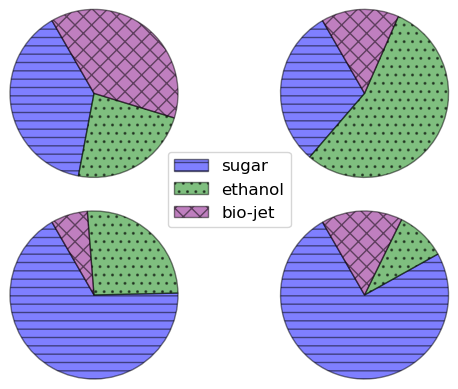

In [8]:
#Create a 4 pie charts to show product distributions in each operating mode
fig, ax = plt.subplots(2,2)

labels=['sugar','ethanol','bio-jet']

color=['blue','green','purple']

patterns = [ "--", '..' , "xx"]

ax[0,0].pie(np.array(region1)/region1tot, radius=1.25, labels=labels, startangle=120,wedgeprops=dict(edgecolor='black',alpha=0.5), colors = color, hatch=['--', '..', 'xx'],pctdistance=0.8, labeldistance=None, textprops=dict(fontsize=12))

ax[0,1].pie(np.array(region2)/region2tot,radius=1.25, labels=labels, startangle=120,wedgeprops=dict(edgecolor='black',alpha=0.5),colors = color, hatch=['--', '..', 'xx'],pctdistance=0.8, labeldistance=None, textprops=dict(fontsize=12))

ax[1,0].pie(np.array(region3)/region3tot,radius=1.25, labels=labels, startangle=120,wedgeprops=dict(edgecolor='black',alpha=0.5),colors = color, hatch=['--', '..', 'xx'],pctdistance=0.75, labeldistance=None, textprops=dict(fontsize=12))

ax[1,1].pie(np.array(region4)/region4tot,  radius=1.25, labels=labels, startangle=120,wedgeprops=dict(edgecolor='black',alpha=0.5),colors = color, hatch=['--', '..', 'xx'],pctdistance=0.75, labeldistance=None, textprops=dict(fontsize=12))

plt.legend(bbox_to_anchor=(0.11, 1.4),fontsize = 12)

plt.savefig('piecharts.png',bbox_inches='tight', dpi=500)

plt.show()

### Sensitivty Analysis to Bio-jet Fuel Premiums

#### Conventional ATJ Technology

In [9]:
#Specify conventional ATJ technology cost and conversion parameters
conv = 0.409 #m3 jet/m3 eth
cost = 637 #$R/m3 jet

#Range of premium prices considered
prem_range_USD = np.linspace(0,2,41) #Premium range in USD/L
prem_range_R = prem_range_USD*5.17*1000 #Premium range in $R/m3

#Uncomment code below to run sensitvity analysis, estimated time to run ~2 hour

# this_file_path = os.getcwd()

# # create a directory to save results
# results_dir = os.path.join(this_file_path, "premium_sensitivity_data")
# if not os.path.isdir(results_dir):
#     os.mkdir(results_dir)

# #Loop through premium prices and save result as a csv file
# for i in range(len(prem_range_R)):
#     data = perfect_information_data_gen(conv,cost,prem_range_R[i],market_prices,scenarios)
#     #Save data to csv files
#     #Region 1
#     data[0].to_csv(results_dir + '/conventional_region1_'+str(i)+'.csv')
#     #Region 2
#     data[1].to_csv(results_dir + '/conventional_region2_'+str(i)+'.csv')
#     #Region 3
#     data[2].to_csv(results_dir + '/conventional_region3_'+str(i)+'.csv')
#     #Region 4
#     data[3].to_csv(results_dir + '/conventional_region4_'+str(i)+'.csv')


# print('DONE')

#### Optimistic ATJ Technology

In [10]:
#Specify optimistic ATJ technology cost and conversion parameters
conv = 0.61 #m3 jet/m3 eth
cost = 461 #$R/m3 jet
gasconv = 0 #m3 gas/m3 eth
dconv = 0 #m3 diesel/m3 eth

#Uncomment code below to run sensitvity analysis, estimated time to run ~2 hour
# #Loop through premium prices and save result as a csv file
# for i in range(len(prem_range_R)):
#     data = perfect_information_data_gen(conv,cost,prem_range_R[i],market_prices,scenarios)
#     #Save data to csv files
#     #Region 1
#     data[0].to_csv(results_dir + '/optimistic_region1_'+str(i)+'.csv')
#     #Region 2
#     data[1].to_csv(results_dir + '/optimistic_region2_'+str(i)+'.csv')
#     #Region 3
#     data[2].to_csv(results_dir + '/optimistic_region3_'+str(i)+'.csv')
#     #Region 4
#     data[3].to_csv(results_dir + '/optimitic_region4_'+str(i)+'.csv')


# print('DONE')

In [11]:
#Pull Existing Results Files from Github
#Conventional ATJ Technology
region1_conventional = []
region2_conventional = []
region3_conventional = []
region4_conventional = [] 

for i in range(len(prem_range_R)):
    region1 = pd.read_csv('https://raw.githubusercontent.com/dowlinglab/a-case-for-biojet-in-Brazil/refs/heads/main/premium_sensitivity_data/conventional_region1_'+str(i)+'.csv')
    region2 = pd.read_csv('https://raw.githubusercontent.com/dowlinglab/a-case-for-biojet-in-Brazil/refs/heads/main/premium_sensitivity_data/conventional_region2_'+str(i)+'.csv')
    region3 = pd.read_csv('https://raw.githubusercontent.com/dowlinglab/a-case-for-biojet-in-Brazil/refs/heads/main/premium_sensitivity_data/conventional_region3_'+str(i)+'.csv')
    region4 = pd.read_csv('https://raw.githubusercontent.com/dowlinglab/a-case-for-biojet-in-Brazil/refs/heads/main/premium_sensitivity_data/conventional_region4_'+str(i)+'.csv')

    #Calculate the fraction of scenarios in each region
    region1_conventional.append(len(region1['ratio1'])/len(scenarios))
    region2_conventional.append(len(region2['ratio1'])/len(scenarios))
    region3_conventional.append(len(region3['ratio1'])/len(scenarios))
    region4_conventional.append(len(region4['ratio1'])/len(scenarios))

#Optimistic ATJ Technology
region1_optimistic = []
region2_optimistic = []
region3_optimistic = []
region4_optimistic = [] 

for i in range(len(prem_range_R)):
    region1 = pd.read_csv('https://raw.githubusercontent.com/dowlinglab/a-case-for-biojet-in-Brazil/refs/heads/main/premium_sensitivity_data/optimistic_region1_'+str(i)+'.csv')
    region2 = pd.read_csv('https://raw.githubusercontent.com/dowlinglab/a-case-for-biojet-in-Brazil/refs/heads/main/premium_sensitivity_data/optimistic_region2_'+str(i)+'.csv')
    region3 = pd.read_csv('https://raw.githubusercontent.com/dowlinglab/a-case-for-biojet-in-Brazil/refs/heads/main/premium_sensitivity_data/optimistic_region3_'+str(i)+'.csv')
    region4 = pd.read_csv('https://raw.githubusercontent.com/dowlinglab/a-case-for-biojet-in-Brazil/refs/heads/main/premium_sensitivity_data/optimistic_region4_'+str(i)+'.csv')

    #Calculate the fraction of scenarios in each region
    region1_optimistic.append(len(region1['ratio1'])/len(scenarios))
    region2_optimistic.append(len(region2['ratio1'])/len(scenarios))
    region3_optimistic.append(len(region3['ratio1'])/len(scenarios))
    region4_optimistic.append(len(region4['ratio1'])/len(scenarios))

#### Visualization

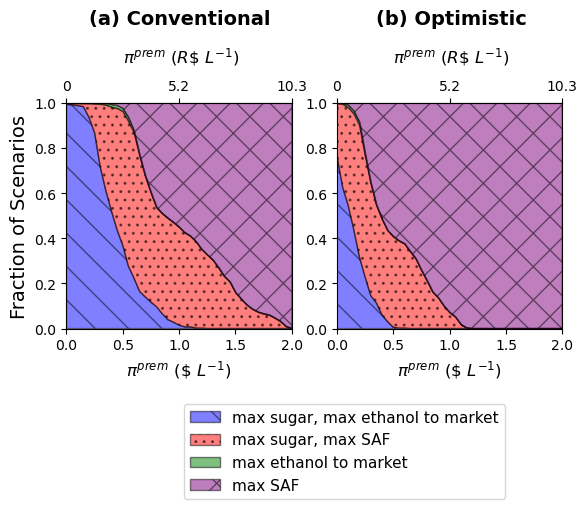

In [12]:
#Create 2 dictionaries to compress data for all regions for the optimistic and conventional cases
#Conventional
df_conventional = pd.DataFrame({
    'blue': region1_conventional,
    'red': region2_conventional,
    'green': region3_conventional,
    'purple': region4_conventional,
}, index= prem_range_USD)

#Optimistic
df_optimistic = pd.DataFrame({
    'blue': region1_optimistic,
    'red': region2_optimistic,
    'green': region3_optimistic,
    'purple': region4_optimistic,
}, index= prem_range_USD)

fig, (ax1, ax2) = plt.subplots(ncols=2)
ax1.set_box_aspect(1)
ax2.set_box_aspect(1)

index= prem_range_USD

#left - Conventional
stacks = ax1.stackplot(index,df_conventional['blue'], df_conventional['red'], df_conventional['green'],df_conventional['purple'], alpha = 0.5, edgecolor = 'k', hatch = ['x'], colors=['blue','red','green','purple'], labels = ['max sugar, max ethanol to market','max sugar, max SAF','max ethanol to market','max SAF'])
ax1.set_xlabel( r'$\pi^{prem}$ ' + r'$ (\$ \ L^{-1})$', fontsize = 12, fontweight='bold')
ax1.set_ylabel('Fraction of Scenarios', fontsize=14)
ax1.text(0.2,1.35,'(a) Conventional', fontweight='bold',fontsize = 14)
ax1.text(0.5, 1.18, r'$\pi^{prem}$ ' + r'$ (R\$ \ L^{-1})$', fontsize=12)
secax = ax1.secondary_xaxis(1)
secax.set_xticks([0, 1, 2], labels = [0,5.2,10.3])
ax1.set(xlim=(0, 2),
       ylim=(0, 1))
hatches=["\\", "..",None,'x']
for stack, hatch in zip(stacks, hatches):
    stack.set_hatch(hatch)


#left - Conventional
stacks = ax2.stackplot(index,df_optimistic['blue'], df_optimistic['red'], df_optimistic['green'],df_optimistic['purple'], alpha = 0.5, edgecolor = 'k', colors=['blue','red','green','purple'], labels = ['max sugar, max ethanol to market','max sugar, max SAF','max ethanol to market','max SAF'])
ax2.set_xlabel(r'$\pi^{prem}$ ' + r'$ (\$ \ L^{-1})$', fontsize = 12)
ax2.text(0.5, 1.18, r'$\pi^{prem}$ ' + r'$ (R\$ \ L^{-1})$', fontsize=12)
ax2.text(0.35,1.35,'(b) Optimistic', fontweight='bold',fontsize = 14)
ax2.set(xlim=(0, 2),
       ylim=(0, 1))
secax2 = ax2.secondary_xaxis(1)
secax2.set_xticks([0, 1, 2], labels = [0,5.2,10.3])
hatches=["\\", "..",None,'x']
for stack, hatch in zip(stacks, hatches):
    stack.set_hatch(hatch)
ax2.legend(bbox_to_anchor=(0.78, -0.3),fontsize = 11)

plt.subplots_adjust(wspace = 0.2, hspace = 0.4)
plt.savefig('2panel_1dsensitivity_v2.png',bbox_inches='tight', dpi=300)
plt.show()


### 2D Sensitivty Analysis to ATJ Technology Conversion and Cost

In [13]:
#Specify a range of SAF premiums to conduct the 2D sensitivty analysis
prem_range_USD = np.linspace(0,1.25,6) #Premium range in USD/L
prem_range_R = prem_range_USD*5.17*1000 #Premium range in $R/m3

#Specify a range of conversion and cost parameters
conv_array = np.linspace(0,1,11) #ATJ Conversion range
opex_array = np.linspace(0,1750,11) #ATJ OPEX range ($R)
opex_array_USD = np.linspace(0,500,11)

#Uncomment to run technology sensitivity analysis
# #Loop through_premiums
# for i in range(len(prem_range_R)):
#     data = sensitivity2d_data_gen(conv_array,opex_array,prem_range_R[i],market_prices,scenarios, gasconv = 0, dconv=0)
#     #Save data to CSV file
#     data.to_csv(results_dir + '/2D_sensitivity_' + str(i) + '.csv')

In [14]:
#Create an enpty dict to store read in technology sensitivity data results files from GitHub
technology_sensitivity = {}
for i in range(len(prem_range_R)):
    technology_sensitivity[i] = pd.read_csv('https://raw.githubusercontent.com/dowlinglab/a-case-for-biojet-in-Brazil/refs/heads/main/premium_sensitivity_data/2D_sensitivity_'+str(i)+'.csv')
    technology_sensitivity[i] = technology_sensitivity[i].drop(columns = ['Unnamed: 0'])

### Visualization

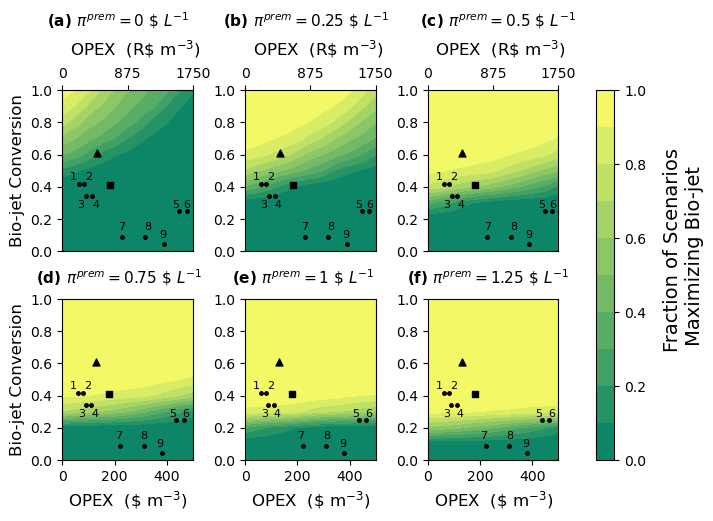

In [15]:
fig, axs = plt.subplots(2, 3)

#upper left - heat map
cntr = axs[0,0].contourf(opex_array,conv_array,technology_sensitivity[0].to_numpy(),cmap='summer',levels=[0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1])
#Add scatter points for conventional and optimistic case
axs[0,0].scatter(637,0.409,color = 'k', marker='s', s = 25)
axs[0,0].scatter(461,0.61,color = 'k', marker='^', s = 25)
axs[0,0].scatter(1114,0.084,color = 'k', marker='.', s = 25)
axs[0,0].scatter(1665,0.2487,color = 'k', marker='.', s = 25)
axs[0,0].scatter(286,0.416,color = 'k', marker='.', s = 25)
axs[0,0].scatter(394,0.344,color = 'k', marker='.', s = 25)
axs[0,0].scatter(1361,0.045,color = 'k', marker='.', s = 25)
axs[0,0].scatter(796,0.084,color = 'k', marker='.', s = 25)
axs[0,0].scatter(1566,0.2487,color = 'k', marker='.', s = 25)
axs[0,0].scatter(218,0.416,color = 'k', marker='.', s = 25)
axs[0,0].scatter(319,0.344,color = 'k', marker='.', s = 25)
axs[0,0].text(-200,1.4,r'(a) $\pi^{prem} = 0  \ \$ \ L^{-1}$', fontsize = 11, fontweight='bold')
axs[0,0].xaxis.tick_top()
axs[0,0].set_xticks([0,875,1750])
axs[0,0].set_ylabel('Bio-jet Conversion', fontsize = 12)
axs[0,0].text(100,1.22,r'OPEX  (R\$ m$^{-3}$)', fontsize = 12)
axs[0,0].text(100,.44,'1', fontsize = 8)
axs[0,0].text(300,.44,'2', fontsize = 8)
axs[0,0].text(200,.27,'3', fontsize = 8)
axs[0,0].text(400,.27,'4', fontsize = 8)
axs[0,0].text(1475,.27,'5',fontsize = 8)
axs[0,0].text(1625,.27,'6',fontsize = 8)
axs[0,0].text(750,.13,'7',fontsize = 8)
axs[0,0].text(1100,.13,'8',fontsize = 8)
axs[0,0].text(1300,.08,'9',fontsize = 8)


#upper right - heat map
cntr = axs[0,1].contourf(opex_array,conv_array,technology_sensitivity[1].to_numpy(), cmap='summer',levels=10)
#Add scatter points for conventional and optimistic case
axs[0,1].scatter(637,0.409,color = 'k', marker='s', s = 25)
axs[0,1].scatter(1114,0.084,color = 'k', marker='.', s = 25)
axs[0,1].scatter(1665,0.2487,color = 'k', marker='.', s = 25)
axs[0,1].scatter(286,0.416,color = 'k', marker='.', s = 25)
axs[0,1].scatter(394,0.344,color = 'k', marker='.', s = 25)
axs[0,1].scatter(1361,0.045,color = 'k', marker='.', s = 25)
axs[0,1].scatter(796,0.084,color = 'k', marker='.', s = 25)
axs[0,1].scatter(1566,0.2487,color = 'k', marker='.', s = 25)
axs[0,1].scatter(218,0.416,color = 'k', marker='.', s = 25)
axs[0,1].scatter(319,0.344,color = 'k', marker='.', s = 25)
axs[0,1].scatter(461,0.61,color = 'k', marker='^', s = 25)
axs[0,1].xaxis.tick_top()
axs[0,1].set_xticks([0,875,1750])
axs[0,1].text(-300,1.4,r'(b) $\pi^{prem} = 0.25  \ \$ \ L^{-1}$', fontsize = 11, fontweight='bold')
axs[0,1].text(100,1.22,r'OPEX  (R\$ m$^{-3}$)', fontsize = 12)
axs[0,1].text(100,.44,'1', fontsize = 8)
axs[0,1].text(300,.44,'2', fontsize = 8)
axs[0,1].text(200,.27,'3', fontsize = 8)
axs[0,1].text(400,.27,'4', fontsize = 8)
axs[0,1].text(1475,.27,'5',fontsize = 8)
axs[0,1].text(1625,.27,'6',fontsize = 8)
axs[0,1].text(750,.13,'7',fontsize = 8)
axs[0,1].text(1100,.13,'8',fontsize = 8)
axs[0,1].text(1300,.08,'9',fontsize = 8)


#bottom left - heat map
cntr = axs[0,2].contourf(opex_array,conv_array,technology_sensitivity[2].to_numpy(),  cmap='summer',levels=10)
fig.colorbar(cntr, ax = axs, anchor=(2,1))
#Add scatter points for conventional and optimistic case
axs[0,2].scatter(637,0.409,color = 'k', marker='s', s = 25)
axs[0,2].scatter(1114,0.084,color = 'k', marker='.', s = 25)
axs[0,2].scatter(1665,0.2487,color = 'k', marker='.', s = 25)
axs[0,2].scatter(286,0.416,color = 'k', marker='.', s = 25)
axs[0,2].scatter(394,0.344,color = 'k', marker='.', s = 25)
axs[0,2].scatter(1361,0.045,color = 'k', marker='.', s = 25)
axs[0,2].scatter(796,0.084,color = 'k', marker='.', s = 25)
axs[0,2].scatter(1566,0.2487,color = 'k', marker='.', s = 25)
axs[0,2].scatter(218,0.416,color = 'k', marker='.', s = 25)
axs[0,2].scatter(319,0.344,color = 'k', marker='.', s = 25)
axs[0,2].scatter(461,0.61,color = 'k', marker='^', s = 25)
axs[0,2].xaxis.tick_top()
axs[0,2].set_xticks([0,875,1750])
axs[0,2].text(-100,1.4,r'(c) $\pi^{prem} = 0.5  \ \$ \ L^{-1}$', fontsize = 11, fontweight='bold')
axs[0,2].text(100,1.22,r'OPEX  (R\$ m$^{-3}$)', fontsize = 12)
axs[0,2].text(100,.44,'1', fontsize = 8)
axs[0,2].text(300,.44,'2', fontsize = 8)
axs[0,2].text(200,.27,'3', fontsize = 8)
axs[0,2].text(400,.27,'4', fontsize = 8)
axs[0,2].text(1475,.27,'5',fontsize = 8)
axs[0,2].text(1625,.27,'6',fontsize = 8)
axs[0,2].text(750,.13,'7',fontsize = 8)
axs[0,2].text(1100,.13,'8',fontsize = 8)
axs[0,2].text(1300,.08,'9',fontsize = 8)


#bottom right - heat map
cntr = axs[1,0].contourf(opex_array_USD,conv_array,technology_sensitivity[3].to_numpy(),cmap='summer',levels=10)
#Add scatter points for conventional and optimistic case
axs[1,0].scatter(180,0.409,color = 'k', marker='s', s = 25, label = 'conventional [ref]')
axs[1,0].scatter(129,0.61,color = 'k', marker='^', s = 25, label = 'optimistic [ref]')
axs[1,0].scatter(311,0.084,color = 'k', marker='.', s = 25)
axs[1,0].scatter(222,0.084,color = 'k', marker='.', s = 25)
axs[1,0].scatter(437,0.2487,color = 'k', marker='.', s = 25)
axs[1,0].scatter(61,0.416,color = 'k', marker='.', s = 25)
axs[1,0].scatter(89,0.344,color = 'k', marker='.', s = 25)
axs[1,0].scatter(464.5,0.2487,color = 'k', marker='.', s = 25)
axs[1,0].scatter(80.26,0.416,color = 'k', marker='.', s = 25)
axs[1,0].scatter(110,0.344,color = 'k', marker='.', s = 25)
axs[1,0].scatter(380,0.045,color = 'k', marker='.', s = 25)
axs[1,0].text(-100,1.1,r'(d) $\pi^{prem} = 0.75  \ \$ \ L^{-1}$', fontsize = 11, fontweight='bold')
axs[1,0].set_xlabel(r'OPEX  (\$ m$^{-3}$)', fontsize = 12)
axs[1,0].set_ylabel('Bio-jet Conversion', fontsize = 12)
axs[1,0].text(30,.44,'1', fontsize = 8)
axs[1,0].text(85,.44,'2', fontsize = 8)
axs[1,0].text(60,.27,'3', fontsize = 8)
axs[1,0].text(110,.27,'4', fontsize = 8)
axs[1,0].text(410,.27,'5',fontsize = 8)
axs[1,0].text(460,.27,'6',fontsize = 8)
axs[1,0].text(200,.13,'7',fontsize = 8)
axs[1,0].text(300,.13,'8',fontsize = 8)
axs[1,0].text(360,.08,'9',fontsize = 8)


# #bottom right - heat map
cntr = axs[1,1].contourf(opex_array_USD,conv_array,technology_sensitivity[4].to_numpy(),cmap='summer',levels=10)
#Add scatter points for conventional and optimistic case
axs[1,1].scatter(180,0.409,color = 'k', marker='s', s = 25, label = 'conventional [ref]')
axs[1,1].scatter(129,0.61,color = 'k', marker='^', s = 25, label = 'optimistic [ref]')
axs[1,1].scatter(311,0.084,color = 'k', marker='.', s = 25)
axs[1,1].scatter(222,0.084,color = 'k', marker='.', s = 25)
axs[1,1].scatter(437,0.2487,color = 'k', marker='.', s = 25)
axs[1,1].scatter(61,0.416,color = 'k', marker='.', s = 25)
axs[1,1].scatter(89,0.344,color = 'k', marker='.', s = 25)
axs[1,1].scatter(464.5,0.2487,color = 'k', marker='.', s = 25)
axs[1,1].scatter(80.26,0.416,color = 'k', marker='.', s = 25)
axs[1,1].scatter(110,0.344,color = 'k', marker='.', s = 25)
axs[1,1].scatter(380,0.045,color = 'k', marker='.', s = 25)
axs[1,1].text(-50,1.1,r'(e) $\pi^{prem} = 1  \ \$ \ L^{-1}$', fontsize = 11, fontweight='bold')
axs[1,1].set_xlabel(r'OPEX  (\$ m$^{-3}$)', fontsize = 12)
axs[1,1].text(30,.44,'1', fontsize = 8)
axs[1,1].text(85,.44,'2', fontsize = 8)
axs[1,1].text(60,.27,'3', fontsize = 8)
axs[1,1].text(110,.27,'4', fontsize = 8)
axs[1,1].text(410,.27,'5',fontsize = 8)
axs[1,1].text(460,.27,'6',fontsize = 8)
axs[1,1].text(200,.13,'7',fontsize = 8)
axs[1,1].text(300,.13,'8',fontsize = 8)
axs[1,1].text(360,.08,'9',fontsize = 8)


# #bottom right - heat map
cntr = axs[1,2].contourf(opex_array_USD,conv_array,technology_sensitivity[5].to_numpy(),cmap='summer',levels=10)
#Add scatter points for conventional and optimistic case
axs[1,2].scatter(180,0.409,color = 'k', marker='s', s = 25, label = 'conventional [ref]')
axs[1,2].scatter(129,0.61,color = 'k', marker='^', s = 25, label = 'optimistic [ref]')
axs[1,2].scatter(311,0.084,color = 'k', marker='.', s = 25)
axs[1,2].scatter(222,0.084,color = 'k', marker='.', s = 25)
axs[1,2].scatter(437,0.2487,color = 'k', marker='.', s = 25)
axs[1,2].scatter(61,0.416,color = 'k', marker='.', s = 25)
axs[1,2].scatter(89,0.344,color = 'k', marker='.', s = 25)
axs[1,2].scatter(464.5,0.2487,color = 'k', marker='.', s = 25)
axs[1,2].scatter(80.26,0.416,color = 'k', marker='.', s = 25)
axs[1,2].scatter(110,0.344,color = 'k', marker='.', s = 25)
axs[1,2].scatter(380,0.045,color = 'k', marker='.', s = 25)
axs[1,2].text(-80,1.1,r'(f) $\pi^{prem} = 1.25  \ \$ \ L^{-1}$', fontsize = 11, fontweight='bold')
axs[1,2].set_xlabel(r'OPEX  (\$ m$^{-3}$)', fontsize = 12)
axs[1,2].text(30,.44,'1', fontsize = 8)
axs[1,2].text(85,.44,'2', fontsize = 8)
axs[1,2].text(60,.27,'3', fontsize = 8)
axs[1,2].text(110,.27,'4', fontsize = 8)
axs[1,2].text(410,.27,'5',fontsize = 8)
axs[1,2].text(460,.27,'6',fontsize = 8)
axs[1,2].text(200,.13,'7',fontsize = 8)
axs[1,2].text(300,.13,'8',fontsize = 8)
axs[1,2].text(360,.08,'9',fontsize = 8)

plt.text(900,0.7, 'Fraction of Scenarios \n Maximizing Bio-jet', fontsize = 14, rotation = 90)
plt.subplots_adjust(wspace = 0.4, hspace = 0.3)
plt.savefig('4panel2dsensitivty.png',bbox_inches='tight',dpi=400)
plt.show()
